In [1]:
%run Classifier_class.ipynb

In [2]:
class KNN_Classifier(Classifier):
    def run(self, gene_ids):
        super().run(gene_ids)
        
        # Here can go the code to run the SVM classifier itself. For now code it below.
        # Output prediction list and true list

In [5]:
# Initialize an SVM classifier instance
c = KNN_Classifier()
preselected_ensgs = pd.read_csv('data/preselectedList', names=['ENSG'])

# Function to perform grid search for hyperparameters

In [9]:
import numpy as np
import pandas as pd

from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, f1_score, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [7]:
def grid_search_wrapper(model, train_values, train_labels, test_values, test_labels, refit_score='recall_score'):
    """
    Fit GridSearchCV classifier and print out scores
    """
    param_options = {
        'n_neighbors' : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'weights' : ['distance', 'uniform'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
        'p' : [1, 2, 3]
    }

    score_options = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score),   
    }
    
    skf = StratifiedKFold(n_splits=3)
    grid_search = GridSearchCV(model, param_grid=param_options, scoring=score_options, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_values, train_labels)

    # make the predictions
    predicted_test_labels = grid_search.predict(test_values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of SVM optimized for {} on the test data:'.format(refit_score))
    print(test_labels)
    print(predicted_test_labels)
    print(pd.DataFrame(confusion_matrix(test_labels, predicted_test_labels),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

# Perform grid search to optimize hyper parameters

In [17]:
# Random seed for reproducibility
SEED = 10

#gene_ids = ['ENSG00000000003', 'ENSG00000000005', 'ENSG12'] # for example...

#c.run(None)
c.run(list(preselected_ensgs.ENSG))

def run_override(data, parameters=None):
    # Code the SVM classification process here for now, so that you don't have to reinstantiate the classifier 
    # (block above) every time you make a change. Parameters are optional, no need to include them until fine-tuning
    # probably.
        
    # Extract the labels
    labels = np.array(c.subsetted_tpm.index.get_level_values(1))
    
    train, test, train_labels, test_labels = train_test_split(data, 
                                                              labels, 
                                                              stratify = labels,
                                                              test_size = 0.4, 
                                                              random_state = SEED)
    
    print('\t{} examles in training set'.format(len(train)))
    print('\t{} examples in test set'.format(len(test)))
    
    print('\t{}: fraction of positives in training set'.format(
        sum(train.index.get_level_values(1))/len(train.index.get_level_values(1))))
    print('\t{}: fraction of positives in test set'.format(
        sum(test.index.get_level_values(1))/len(test.index.get_level_values(1))))   
    
    model = neighbors.KNeighborsClassifier()
    
    return grid_search_wrapper(model, train, train_labels, test, test_labels)
    
grid_search_results = run_override(c.subsetted_tpm)

Running classifier with 60675 genes...
	57 examles in training set
	39 examples in test set
	0.2982456140350877: fraction of positives in training set
	0.28205128205128205: fraction of positives in test set
Best params for recall_score
{'algorithm': 'ball_tree', 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

Confusion matrix of SVM optimized for recall_score on the test data:
[0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0]
     pred_neg  pred_pos
neg        27         1
pos         7         4


In [13]:
results = pd.DataFrame(grid_search_results.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'param_n_neighbors', 
         'param_weights', 'param_algorithm', 'param_p']].round(3)[0:40]

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,param_n_neighbors,param_weights,param_algorithm,param_p
28,0.389,0.189,0.250,7,distance,ball_tree,3
88,0.178,0.189,0.182,4,distance,kd_tree,3
106,0.389,0.189,0.250,7,distance,kd_tree,3
237,0.194,0.189,0.188,3,uniform,auto,2
236,0.194,0.189,0.188,3,distance,auto,2
158,0.194,0.189,0.188,3,distance,brute,2
159,0.194,0.189,0.188,3,uniform,brute,2
262,0.389,0.189,0.250,7,distance,auto,3
29,0.389,0.189,0.250,7,uniform,ball_tree,3
166,0.178,0.189,0.182,4,distance,brute,3


# Run Model with Optimized Hyperparameters

Running classifier with 60675 genes...
	57 examles in training set
	39 examples in test set
	0.2982456140350877: fraction of positives in training set
	0.28205128205128205: fraction of positives in test set
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
 0 0]
[0.49230193 0.30238298 0.         0.24836369 0.         0.24867887
 0.         0.25349232 0.         0.         0.         0.26265021
 0.75084571 0.23445159 0.50685213 0.         0.         0.50634923
 0.49990029 0.         0.         0.24325838 0.         0.25250808
 0.         0.74135985 0.         0.23183883 0.48269753 0.
 0.         0.         0.         0.         0.22550416 0.23932443
 0.50396475 0.         0.2559809 ]
0.6136363636363635
Threshold of 0.1
     pred_neg  pred_pos
neg        15        13
pos         4         7
Threshold of 0.2
     pred_neg  pred_pos
neg        15        13
pos         4         7
Threshold of 0.3
     pred_neg  pred_pos
neg        23         5
pos         7        

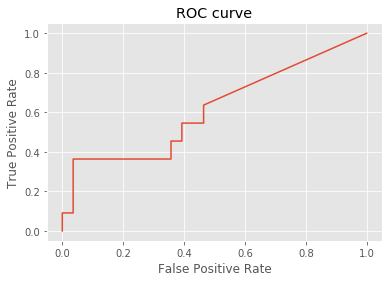

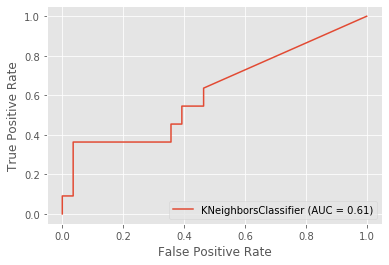

In [20]:
#gene_ids = ['ENSG00000000003', 'ENSG00000000005', 'ENSG12'] # for example...

#c.run(list(preselected_ensgs.ENSG))
c.run(None)

def run_override_using_optimal(data, parameters=None):
    # Code the SVM classification process here for now, so that you don't have to reinstantiate the classifier 
    # (block above) every time you make a change. Parameters are optional, no need to include them until fine-tuning
    # probably.
    
    # Extract the labels
    labels = np.array(c.subsetted_tpm.index.get_level_values(1))
    
    train, test, train_labels, test_labels = train_test_split(data, 
                                                              labels, 
                                                              stratify = labels,
                                                              test_size = 0.4, 
                                                              random_state = SEED)

    print('\t{} examles in training set'.format(len(train)))
    print('\t{} examples in test set'.format(len(test)))
    
    print('\t{}: fraction of positives in training set'.format(
        sum(train.index.get_level_values(1))/len(train.index.get_level_values(1))))
    print('\t{}: fraction of positives in test set'.format(
        sum(test.index.get_level_values(1))/len(test.index.get_level_values(1))))    
    
    # Make a model
    model = neighbors.KNeighborsClassifier(n_neighbors = 4, 
                                            weights = 'distance',
                                            algorithm = 'ball_tree',
                                            p = 2)
        
    # Train model
    model.fit(train, train_labels)
    #print(model.score(test, test_labels))
    
    # Guesses
    guesses = model.predict(test)
    print(guesses)
    
    # Probabilities per class
    probs = model.predict_proba(test)[:, 1]
    print(probs)
    
    # Calculate roc auc
    roc_value = roc_auc_score(test_labels, probs)
    print(roc_value)
    
    # Learn to predict each class against the other
    #test_scores = model.fit(scaled_train, train_labels).decision_function(scaled_test)
    
    # Adjusted
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        print('Threshold of {}'.format(threshold))
        adjusted_guesses = [1 if p >= threshold else 0 for p in probs]
        print(pd.DataFrame(confusion_matrix(test_labels, adjusted_guesses),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
        
    fpr, tpr, thresholds = roc_curve(test_labels, probs, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    
    svc_disp = plot_roc_curve(model, test, test_labels)
    plt.show()
    
run_override_using_optimal(c.subsetted_tpm)